

# Data Cleaning and Analysing - Assignment

**Handling missing values**

To get started, I imported the libraries and the dataset as well as I used `df.info()` to understand the structure of the data. I focused on the numeric columns, since those are the ones we’re most likely to clean and analyze with statistics.

Then, I checked how many missing values there are in each numeric column. This gives a clear idea of which columns need attention before we move forward with analysis.


In [27]:
#Importing libraries 
import pandas as pd

import matplotlib.pyplot as plt

import numpy as np

from scipy.stats import norm

import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression

from sklearn.metrics import r2_score

import itertools
 
#Load dataset
df = pd.read_csv("/kaggle/input/ecommerce-data/ecommerce_store.csv")
 
# Check info to find missing values
df.info()
 
#Select only numeric columns
numeric_cols = df.select_dtypes(include='number').columns
 
#Check for missing values in numeric columns
print(df[numeric_cols].isna().sum())




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   customer_id              1000 non-null   int64  
 1   customer_age             950 non-null    float64
 2   time_on_site             950 non-null    float64
 3   pages_viewed             1000 non-null   int64  
 4   ad_clicks                1000 non-null   int64  
 5   number_of_purchases      1000 non-null   int64  
 6   number_of_returns        1000 non-null   int64  
 7   loyalty_program          1000 non-null   int64  
 8   region                   1000 non-null   object 
 9   average_order_value      950 non-null    float64
 10  total_spend              1000 non-null   float64
 11  customer_lifetime_value  1000 non-null   float64
dtypes: float64(5), int64(6), object(1)
memory usage: 93.9+ KB
customer_id                 0
customer_age               50
time_on_site   

### Visualizing and Filling Missing Values Based on Distribution

**In this step, I looked at how three important columns 'customer_age', 'time_on_site', and 'average_order_value' are distributed. For each one, I printed out the skewness to understand if the data is symmetric or not, and also compared the mean and median to see how the values are spread out.**

I then used a histogram to plot the distribution of each column. This made it easier to decide how to fill in the missing values:

For `customer_age` and `average_order_value`, I filled missing values using the mean, since the distributions looked fairly balanced.
For `time_on_site`, I used the median instead, because the data was skewed and the median gives a better central value in that case.

Finally I double-checked to make sure there were no missing values left in those columns.


customer_age skewness: 0.12
Mean: 35.30, Median: 35.29


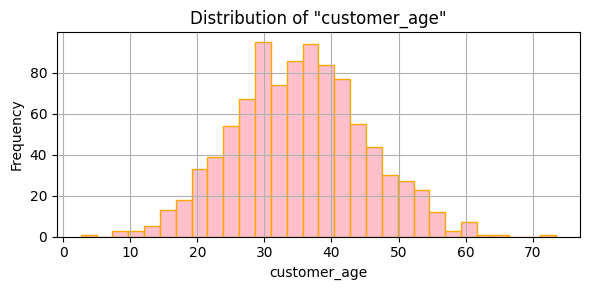

time_on_site skewness: -0.05
Mean: 10.14, Median: 10.14


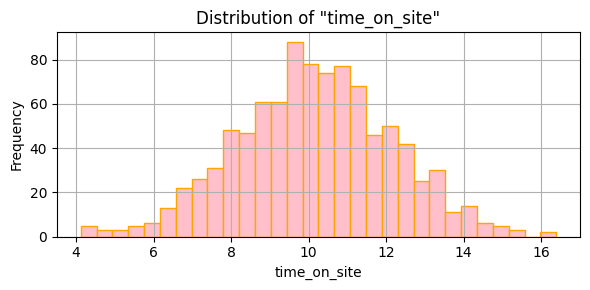

average_order_value skewness: -0.15
Mean: 77.04, Median: 77.57


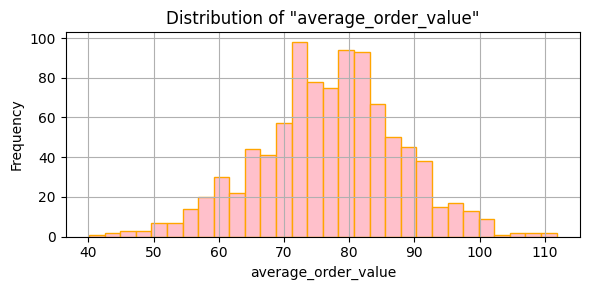

Remaining missing values:
customer_age           0
time_on_site           0
average_order_value    0
dtype: int64


In [28]:
#Plot visualization on the distribution

import matplotlib.pyplot as plt

for col in ['customer_age', 'time_on_site', 'average_order_value']:
    print(f"{col} skewness: {df[col].skew():.2f}") #
    print(f"Mean: {df[col].mean():.2f}, Median: {df[col].median():.2f}")
    plt.figure(figsize=(6, 3))
    plt.hist(df[col].dropna(), bins=30, edgecolor='orange', color='pink')
    plt.title(f'Distribution of "{col}"')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


#Fill missing values based on distribution shape
df['customer_age'] = df['customer_age'].fillna(df['customer_age'].mean()) 
df['time_on_site'] = df['time_on_site'].fillna(df['time_on_site'].median()) 
df['average_order_value'] = df['average_order_value'].fillna(df['average_order_value'].mean())  

#Final check to confirm missing values are filled
print("Remaining missing values:")
print(df[['customer_age', 'time_on_site', 'average_order_value']].isna().sum())




**If the skewness is close to 0, the data is considered normally distributed or symmetric.
If the skewness is greater than +1, the data is strongly right-skewed, meaning there are some large values pulling the distribution to the right.
If the skewness is less than –1, the data is strongly left skewed, meaning there are some very low values pulling the distribution to the left.
If the skewness falls between –0.5 and +0.5, the data is considered approximately symmetric, and it's usually safe to use the mean to fill in missing values.**

**customer_age shows a symmetric distribution, so we’ll fill missing values using the mean.**


# Summary of the overview

In [29]:
#Summary of the columns that where missing values.
summary = {
    'Column': ['customer_age', 'time_on_site', 'average_order_value'],
    'Skewness': [df['customer_age'].skew(), df['time_on_site'].skew(), df['average_order_value'].skew()],
    'Mean': [df['customer_age'].mean(), df['time_on_site'].mean(), df['average_order_value'].mean()],
    'Median': [df['customer_age'].median(), df['time_on_site'].median(), df['average_order_value'].median()]
}

summary_df = pd.DataFrame(summary)
display(summary_df.round(2))

,Column,Skewness,Mean,Median
0,customer_age,0.12,35.30,35.30
1,time_on_site,-0.05,10.14,10.14
2,average_order_value,-0.15,77.04,77.04




### Selecting Numeric Columns for Analysis

**In this part of the code, we first use `select_dtypes(include='number')` to get all the columns in the dataset that contain numeric values. We then filter out the `customerid` column since it's not relevant for our analysis. After that, we print out the list of numeric columns that we’ll be focusing on for further checks or visualizations. This helps ensure we're working only with the data that makes sense for our analysis, leaving out any irrelevant columns.**

To check if there were any strange or extreme values in the data, I looked at all the numeric columns (excluding customerid, since it’s just an ID). I used boxplots to see if any values stood out far from the rest, which could be potential outliers.

I then calculated the interquartile range (IQR) for each column. This helped me set a lower and upper limit, and anything outside those limits was considered an outlier. I removed those rows one column at a time and kept track of how many rows were removed.

After cleaning, I plotted the boxplots again to compare the “before” and “after” version. Some differences were small, but this step still helps make sure the data is more consistent and that the extreme values won’t affect the results later on.




In [30]:
#Importing values
import matplotlib.pyplot as plt

#Get all numeric columns (ignore 'customerid')
numerical_cols = df.select_dtypes(include='number').columns
numerical_cols = [col for col in numerical_cols if col != 'customerid']

print("Numerical columns to check:", numerical_cols) 

Numerical columns to check: ['customer_id', 'customer_age', 'time_on_site', 'pages_viewed', 'ad_clicks', 'number_of_purchases', 'number_of_returns', 'loyalty_program', 'average_order_value', 'total_spend', 'customer_lifetime_value']


# **The Data visualization before removing outliers printed as boxplots.**

This code creates boxplots for each numerical column in the dataset to visualize the distribution of data and identify any potential outliers. For each numerical column, we create a copy of the original dataset so we can compare the results later if needed, then generate a boxplot to show how the data is spread out and highlight any extreme values. We use horizontal boxplots (vert=False) for better readability and add a title to each plot, showing which column it corresponds to. This step helps us check for outliers before we consider removing them from the data.

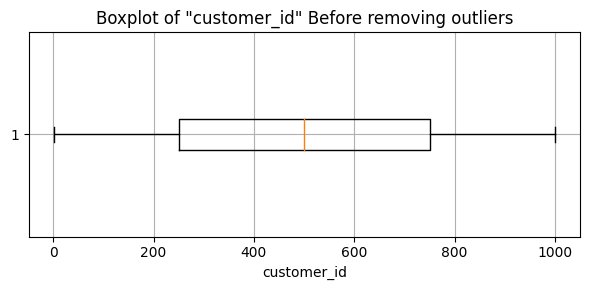

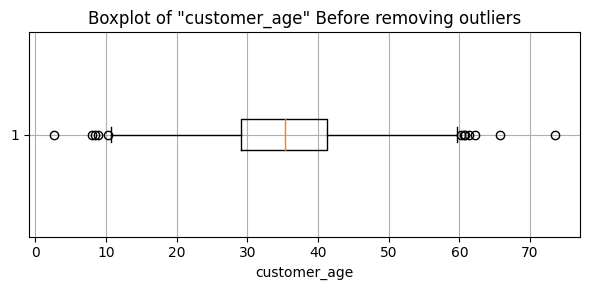

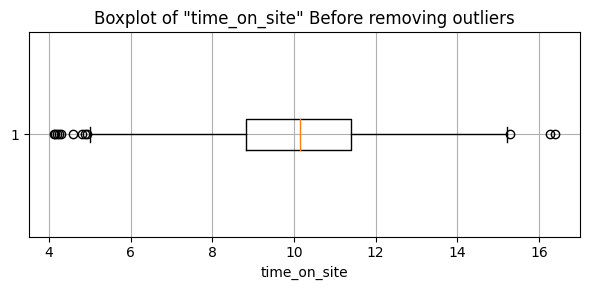

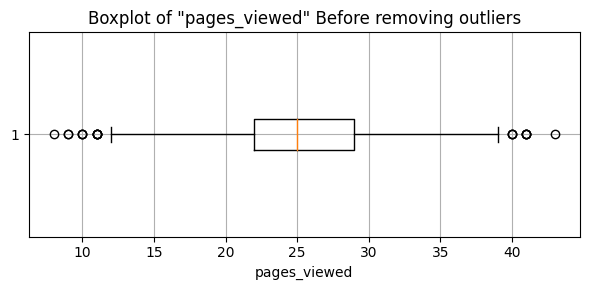

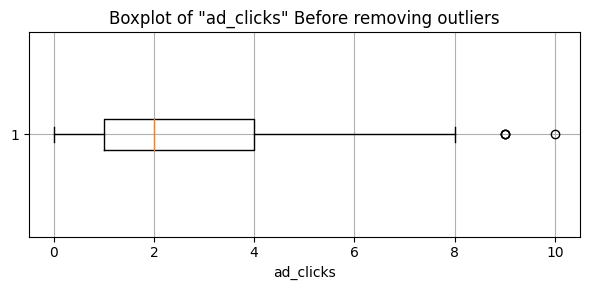

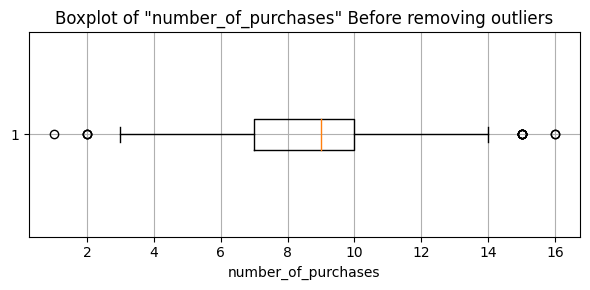

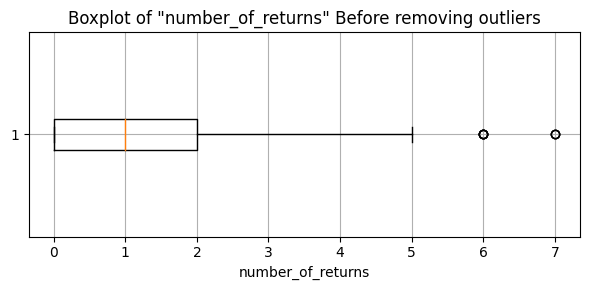

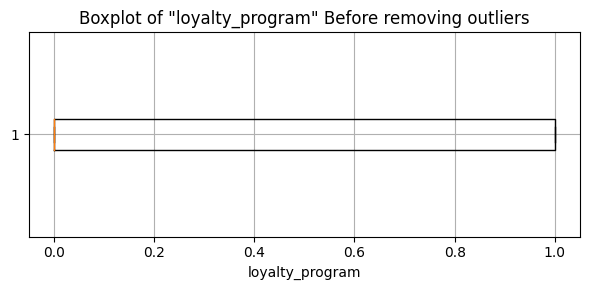

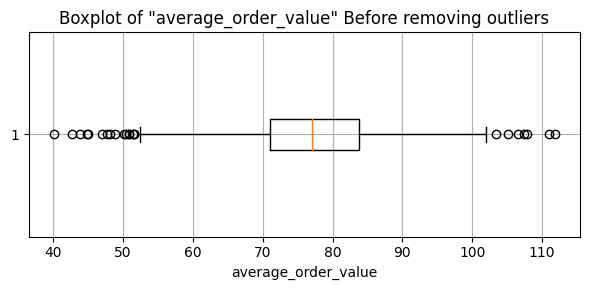

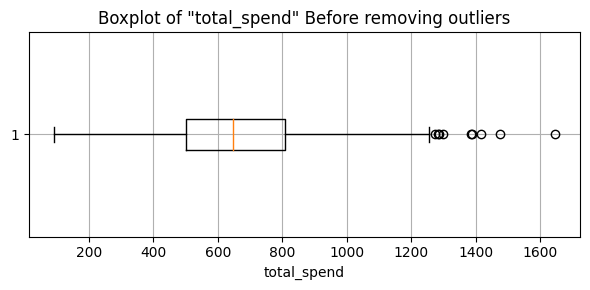

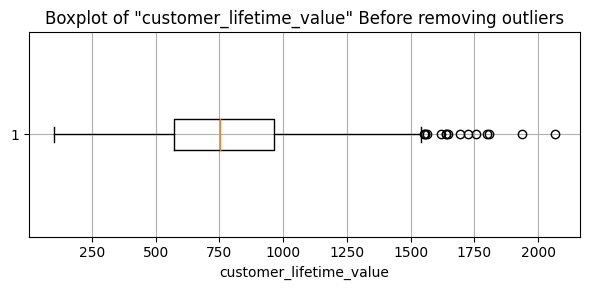

In [31]:
#Boxplots before removing outliers.
for col in numerical_cols: #To keep the original for the comparison using seaborn loool
    original_df = df.copy()
    plt.figure(figsize=(6, 3))
    plt.boxplot(df[col], vert=False)
    plt.title(f'Boxplot of "{col}" Before removing outliers')
    plt.xlabel(col)
    plt.grid(True)
    plt.tight_layout()
    plt.show()



# After removing outliers using the IQR method, I re plotted the boxplots. While visual differences were minimal, the data is now statistically cleaner and better suited for analysis. We can also simply check the Data set in CSV and see the outlier.
 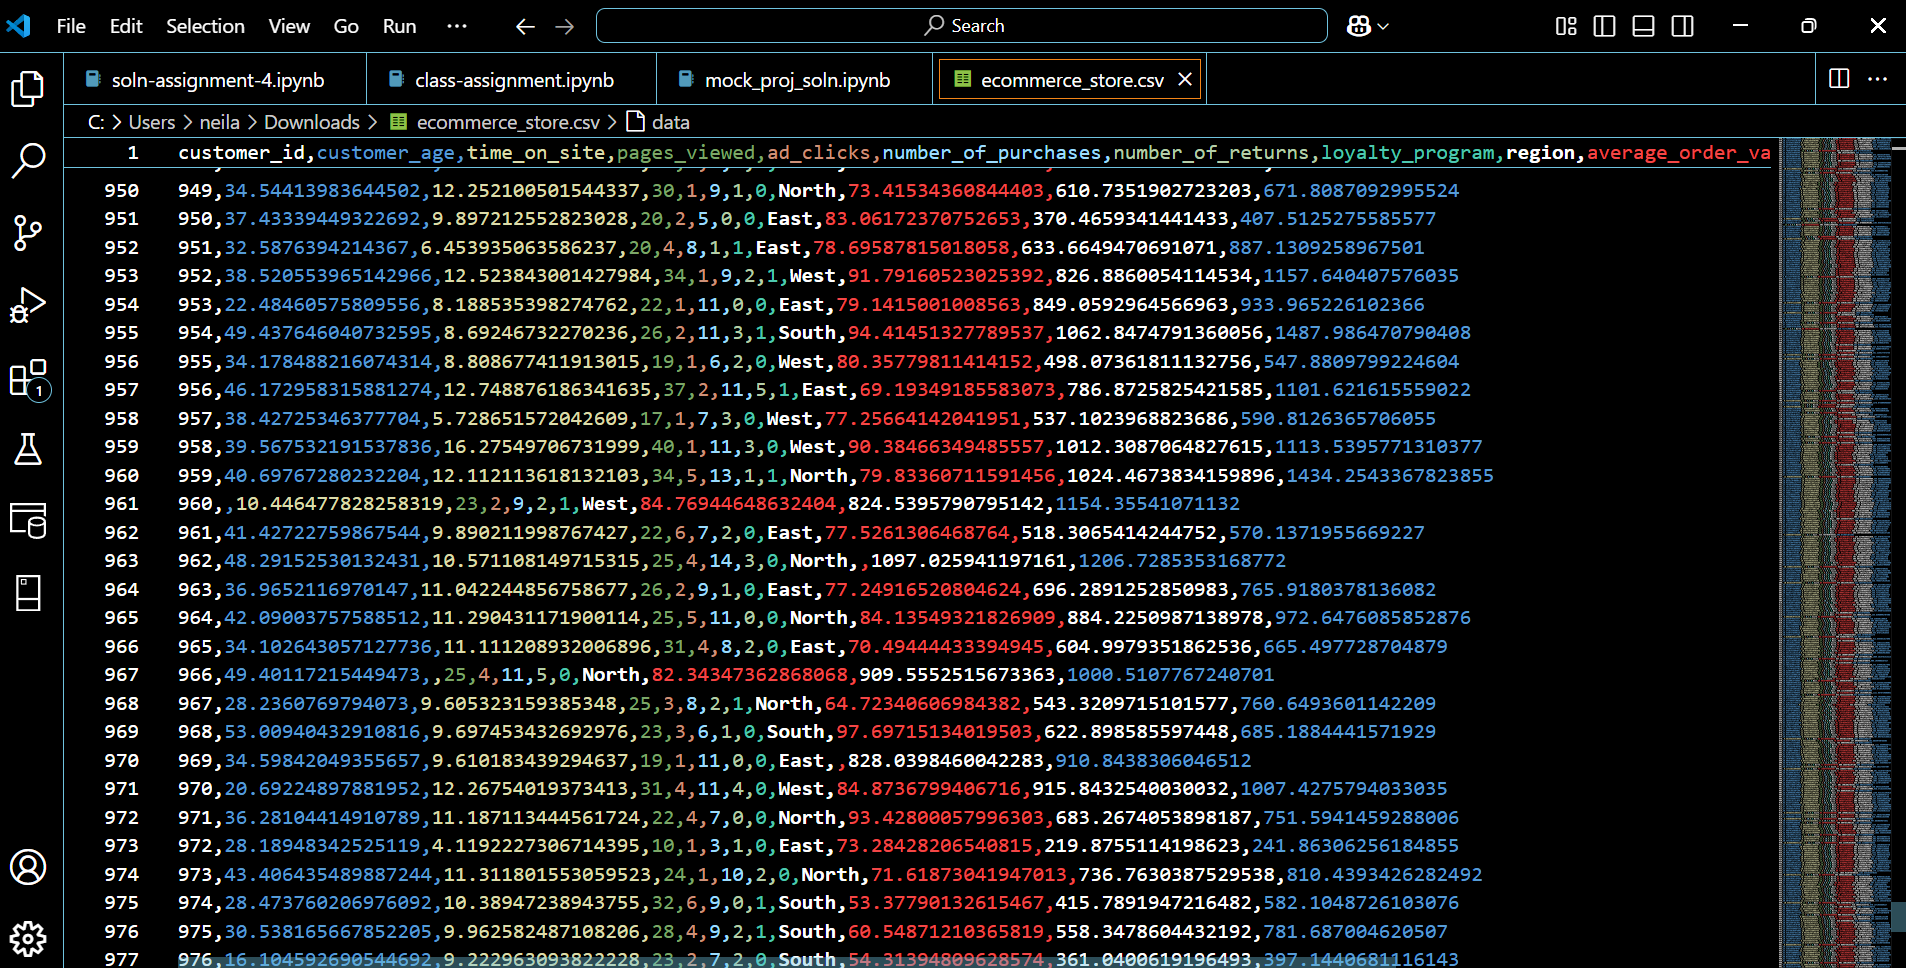



### Removing Outliers with the IQR Method

**In this part, I cleaned up the data by removing outliers from all numerical columns using the IQR (Interquartile Range) method.**

For each numeric column:
I calculated the first quartile (Q1) and third quartile (Q3), which represent the 25th and 75th percentiles of the data.
Then, I calculated the IQR, which is the range between Q3 and Q1.
Using that, I set a lower bound (Q1 - 1.5 × IQR) and an upper bound (Q3 + 1.5 × IQR).
Any data point outside of this range was considered an outlier and removed from the dataset.

After cleaning each column, I printed how many rows were left in the dataset. This step helps make the data more reliable by removing values that are unusually high or low and could mess up the analysis.


In [32]:
#Remove outliers using IQR method.
for col in numerical_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

#Filter the DataFrame
    df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

    print(f'Removed outliers from "{col}". Remaining rows: {len(df)}')




Removed outliers from "customer_id". Remaining rows: 1000
Removed outliers from "customer_age". Remaining rows: 988
Removed outliers from "time_on_site". Remaining rows: 972
Removed outliers from "pages_viewed". Remaining rows: 965
Removed outliers from "ad_clicks". Remaining rows: 961
Removed outliers from "number_of_purchases". Remaining rows: 950
Removed outliers from "number_of_returns". Remaining rows: 943
Removed outliers from "loyalty_program". Remaining rows: 943
Removed outliers from "average_order_value". Remaining rows: 920
Removed outliers from "total_spend". Remaining rows: 917
Removed outliers from "customer_lifetime_value". Remaining rows: 905


# **Visualization of the results after removing the outliers**

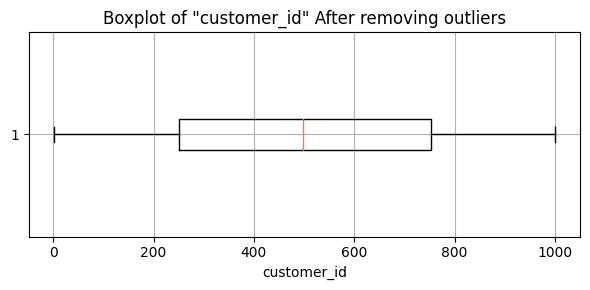

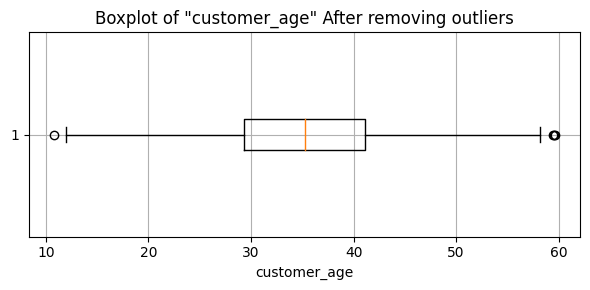

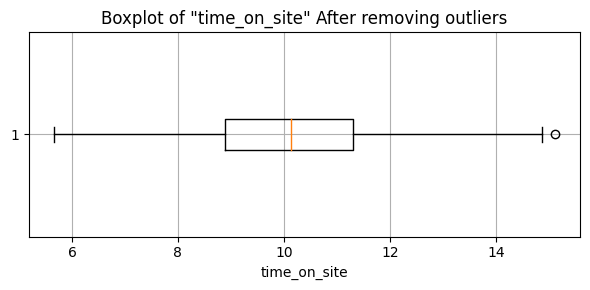

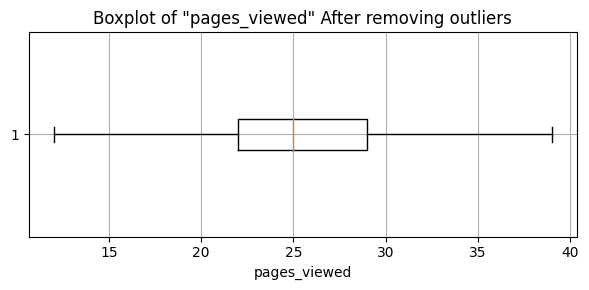

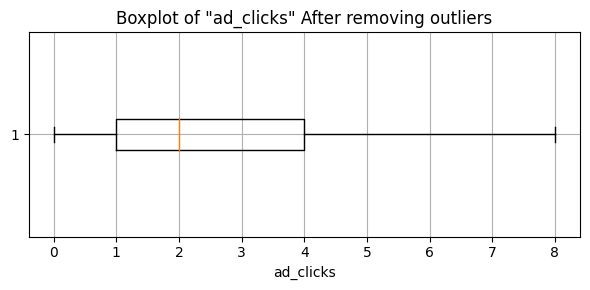

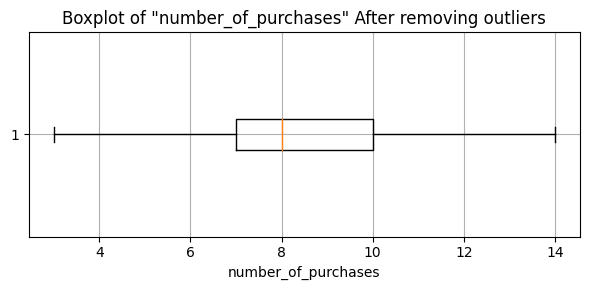

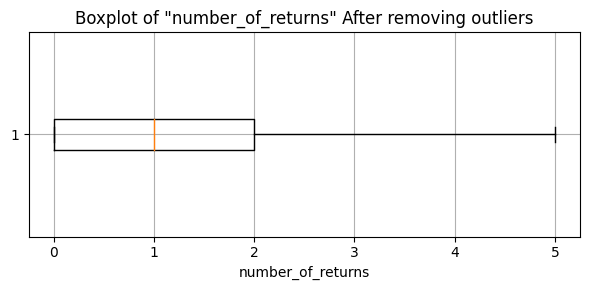

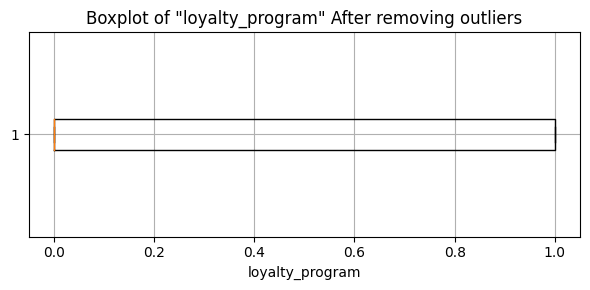

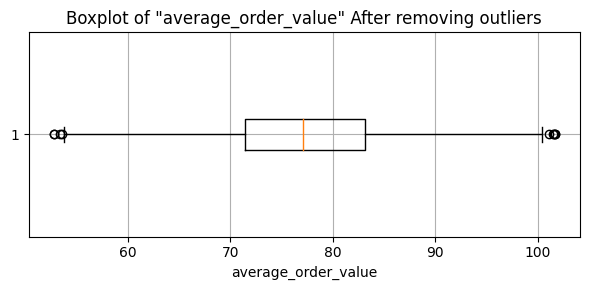

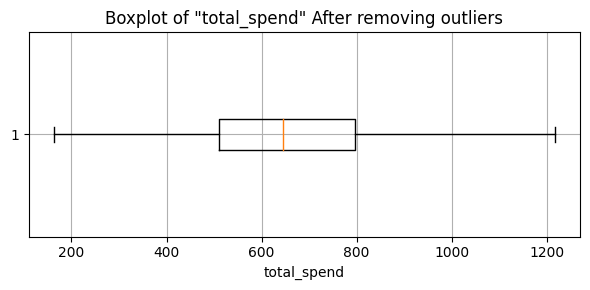

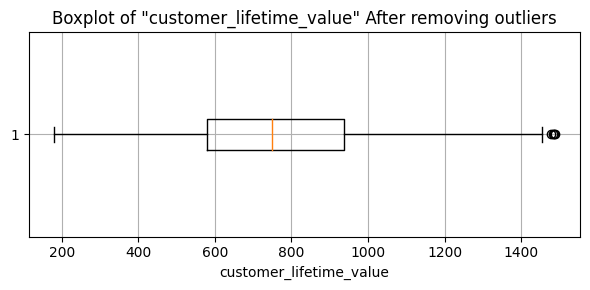

In [33]:
#Boxplots after removing outliers
for col in numerical_cols:
    plt.figure(figsize=(6, 3))
    plt.boxplot(df[col], vert=False)
    plt.title(f'Boxplot of "{col}" After removing outliers')
    plt.xlabel(col)
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    




# Before vs After: Outlier Removal for customer_age. The following side by side boxplot compares the distribution of customer_age before and after removing outliers using the IQR method. We can see how extreme values have been clipped, resulting in a more stable range for analysis.


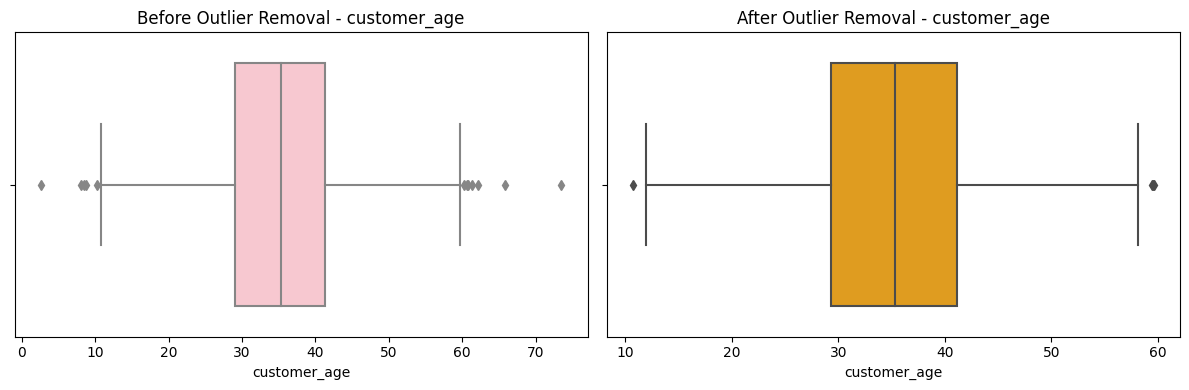

In [34]:
import seaborn as sns

#Side by side comparison of customer_age before and after outlier removal
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
sns.boxplot(x=original_df['customer_age'], color='pink')
plt.title('Before Outlier Removal - customer_age')

plt.subplot(1, 2, 2)
sns.boxplot(x=df['customer_age'], color='orange')
plt.title('After Outlier Removal - customer_age')

plt.tight_layout()
plt.show()

# Now when we have cleansed the data we will move forward with trying to Analyse the data and sample it to see if we can trust these samples. 


**Business Question: Can we trust smaller Data Sets?Is the average customer spending in our random sample significantly different from the overall average spending?**



We took 200 random samples from the total_spend column, and the average (mean) of the samples was 342.50, 
while the population mean was 340.30. We ran a z-test, and the p-value came out to be 0.3867.

Since the p-value (0.3867) is greater than 0.05, we don't have enough evidence to reject the null hypothesis. 
This means that the difference between the sample mean and the population mean is not statistically significant. 
In simpler terms, there's no real difference between the two averages.


### Hypothesis Testing on total_spend Using Z Test

In this step, I wanted to check if a random sample of 200 entries from the total_spend column is significantly different from the population (the entire dataset).

**Here's what I did:**
I took a random sample of 200 values from total_spend. I set random_state=42 to make sure the sample is the same every time I run the code.
I calculated the mean and standard deviation of the sample, and also grabbed the population mean.
Then I calculated the Zscore, which tells me how far away the sample mean is from the population mean, in terms of standard error.
I used the Zscore to get the P value, which helps me decide if the difference between the sample and the population is just by chance or actually significant.
I set my significance level (alpha) to 0.05. This is the threshold for deciding whether to reject the "null hypothesis" (which assumes there's no difference).

**Conclusion:**
If the Pvalue is less than 0.05, I reject the null hypothesis and say there's a significant difference.
If the Pvalue is higher, I keep the null hypothesis and assume the sample and population are not that different.

This helps me understand whether the behavior of this sample group is different enough to matter for future analysis or decisions.


In [35]:
from scipy.stats import norm #I use it in order to compute the Pvalue.
import numpy as np

#Using 200 sample/entries from total_spend column.
#Adding random_state ensures the sample is the same every time.
sample = df['total_spend'].sample(n=200, random_state=42)

#Calculate sample and population statistics. 
sample_mean = sample.mean() 
sample_std = sample.std()
population_mean = df['total_spend'].mean()
n = len(sample)

#Calculate Zscore for the hypothesis testing
z = (sample_mean - population_mean) / (sample_std / np.sqrt(n))

#Compute two tailed Pvalue for the Zscore and multiply with 2 because we care about the difference in both directions. 
p_value = 2 * (1 - norm.cdf(abs(z)))

#I define the significance level.
alpha = 0.05

# Print results
print(f"Sample Mean: {sample_mean:.2f}")
print(f"Population Mean: {population_mean:.2f}")
print(f"Z-score: {z:.2f}")
print(f"P-value: {p_value:.4f}")

#Conclusion 
# # If the Pvalue is smaller than our significance level the alpha, we reject H0 (null hypothesis).
#Otherwise, we fail to reject it.
if p_value < alpha:
    print("Reject the null hypothesis: There is a significant difference.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference.")






Sample Mean: 660.64
Population Mean: 654.66
Z-score: 0.39
P-value: 0.6936
Fail to reject the null hypothesis: There is no significant difference.


**The hypotesis also backs up my previous analysis where I could not detect a significant difference****


# **Linear Regression to look at the correlaton between nummerical column and the total_spendAfter looking at the correlations between the numerical columns and total_spend, here’s what stood out to me:**



Customer lifetime value and number of purchases have the strongest connection to total spending. 
So, people who buy more and stay loyal over time are the ones who end up spending the most.
Average order value and customer age also show some positive correlation, but not as strong. 
This tells me that older customers or those who place more expensive orders might spend more overall but it’s not guaranteed.
Things like pages viewed, number of returns, and time on site seem to have a weaker link to total spend. They could still matter, but maybe not as much.
Ad clicks and customer ID barely show any relationship with spending, so they’re probably not very useful for predictions.
Surprisingly, being in the loyalty program shows a tiny negative correlation. That might mean it’s not leading to more spending or at least not directly.
This gives me a better idea of which features actually matter when it comes to predicting how much someone will spend.


total_spend                1.000000
customer_lifetime_value    0.939151
number_of_purchases        0.906914
average_order_value        0.464315
customer_age               0.427246
pages_viewed               0.302120
number_of_returns          0.283571
time_on_site               0.212867
ad_clicks                  0.133705
customer_id                0.017444
loyalty_program           -0.036293
Name: total_spend, dtype: float64


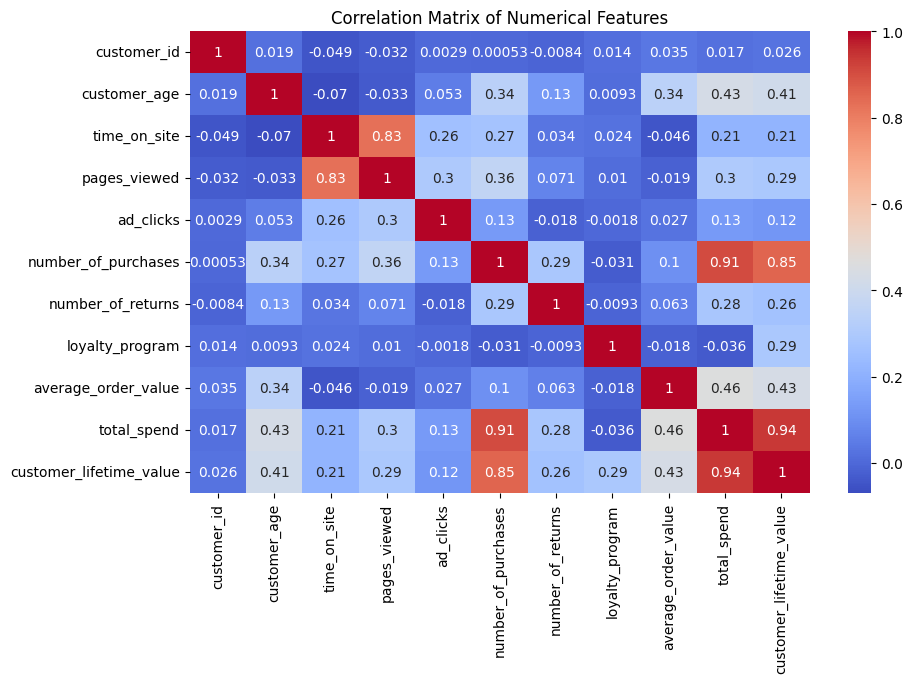

In [36]:
# Only consider numerical columns                                               #CORRECTED
numeric_df = df.select_dtypes(include=['float64', 'int64'])

# Correlation matrix
correlations = numeric_df.corr()

# Sort correlations with total_spend
print(correlations['total_spend'].sort_values(ascending=False))

# Visual correlation heatmap
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.heatmap(correlations, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix of Numerical Features")
plt.show()



### Linear Regression with Top 2 Predictors (Correlation > 0.8)

In this step, I manually selected the two features that showed the strongest positive correlation with `total_spend` in the correlation matrix: `customer_lifetime_value` and `number_of_purchases`.

These two variables were used to build a simple linear regression model. My goal was to predict a customer's total spending based on their lifetime value and how often they purchase.

After training the model I have evaluated its performance using the R² score which tells us how much of the variation in total spend the model is able to explain. A higher R² score means better prediction accuracy.


In [37]:
from sklearn.model_selection import train_test_split                                       #CORRECTED
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Select predictors with corr > 0.8 (manually identified from the matrix)
X = df[['customer_lifetime_value', 'number_of_purchases']]  
y = df['total_spend']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Train model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict and evaluation
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
print(f"R² score with 2 predictors: {r2:.3f}")



R² score with 2 predictors: 0.926


### Visualizing Model Accuracy (Corrected for Multiple Predictors)

To see how well the model performs, I created a scatter plot comparing the **actual** total spend values to the **predicted** ones. 

Since I’m now using more than one predictor (not just one column) I used a general method that works for multiple features. Each dot in the plot shows how close or far the model's prediction was from the real value. 

If the predictions were perfect all dots would fall on the red dashed line. So the closer they are to that line the better the model is doing.

This gives a clear visual overview of how accurate the model is overall.

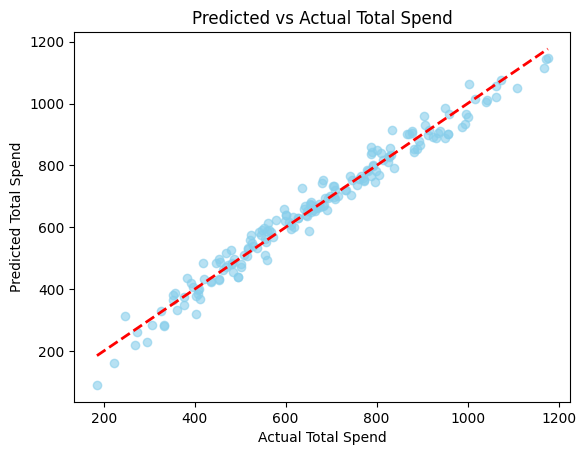

In [42]:
# Plot predicted vs actual total spend (works for any number of predictors)              #CORRECTED FOR SEVERAL PREDICTORS
plt.scatter(y_test, y_pred, alpha=0.6, color='skyblue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2)
plt.xlabel("Actual Total Spend")
plt.ylabel("Predicted Total Spend")
plt.title("Predicted vs Actual Total Spend")
plt.show()

# In this task, I wanted to understand how many unique ways we could organize campaigns based on a customer's region and loyalty status. This is super relevant for marketing strategies because companies often create tailored campaigns depending on where someone lives and how loyal they are as a customer.

**To solve this, I used the itertools.product function, which helps find all the possible combinations between two lists in this case, the unique values in the region and loyalty_status columns. It's basically like creating a grid where every region is matched with every loyalty status.**

**Here's what I did:**
I first extracted the unique values from both columns.
Then, I used product() to generate all the possible pairs.
Lastly, I counted how many combinations were created.
This gave me a clear number of how many different campaign segments we could theoretically target.
Why this matters from a business point of view. It helps marketing teams understand how many personalized campaigns they can run and personalization tends to drive better engagement and sales.

**The Conclusion:** This task showed how many tailored strategies are possible when combining regional and loyalty data. It’s a small step that helps turn raw data into smart decisions.

In [39]:
import itertools

#Get unique values from region and loyalty_program columns
unique_regions = df['region'].dropna().unique()
unique_loyalty_programs = df['loyalty_program'].dropna().unique()

#Calculating the Cartesian product from the regions and loyalty programs
combinations = list(itertools.product(unique_regions, unique_loyalty_programs))

#Outputting the final results
print(f"Total unique campaign combinations: {len(combinations)}")
print("Sample combinations:")
for combo in combinations[:5]:  # Just display the first 5 for readability
    print(combo)

#Print the Toal of the finalized result.
print(f"\nTotal number of unique campaign combinations: {len(combinations)}")

Total unique campaign combinations: 8
Sample combinations:
('South', 0)
('South', 1)
('North', 0)
('North', 1)
('West', 0)

Total number of unique campaign combinations: 8


**So here I wanted to see how close I could get to the actual average total_spend using just samples instead of the full dataset. 
I started by checking the population mean (basically, the average for everyone). Then I tested three different ways of sampling 200 rows to see how they compare.**

Random sampling was just grabbing 200 people at random super straightforward, but it doesn’t really care about things like where people are from. Stratified sampling was a bit smarter it split people up by region first, then took a fair amount from each group. This one usually gives better results if different regions spend differently. Systematic sampling was kind of like picking every nth person in the list, which can work pretty well as long as the data isn’t sorted in a weird way.

In the end, I compared all the sample means to the real one to see how close they got. It was a cool way to understand how different sampling methods can impact the accuracy of what you're trying to estimate.

In [40]:
from sklearn.model_selection import train_test_split  #Same thing here in regards to the import of the libraries but I added another library for train_test_split
import numpy as np

#Setting the seed for reproducibility
np.random.seed(42)

#Population mean
population_mean = df['total_spend'].mean()

#Random Sampling Mean (reusing from Task 3)
random_sample = df['total_spend'].sample(n=200, random_state=42)
random_mean = random_sample.mean()

#Stratified Sampling based on customer Region
stratified_sample = df.groupby('region', group_keys=False).apply(lambda x: x.sample(frac=200/len(df), random_state=42))
stratified_mean = stratified_sample['total_spend'].mean()

#Systematic Sampling and mean.
step = len(df) // 200
systematic_sample = df.iloc[::step][:200] 
systematic_mean = systematic_sample['total_spend'].mean()

#Printing the results here
print(f"Population Mean: {population_mean:.2f}")
print(f"Random Sample Mean: {random_mean:.2f}")
print(f"Stratified Sample Mean: {stratified_mean:.2f}")
print(f"Systematic Sample Mean: {systematic_mean:.2f}")



Population Mean: 654.66
Random Sample Mean: 660.64
Stratified Sample Mean: 651.14
Systematic Sample Mean: 681.61


/tmp/ipykernel_31/2538977664.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  stratified_sample = df.groupby('region', group_keys=False).apply(lambda x: x.sample(frac=200/len(df), random_state=42))


### Extra Credit 3: Model Improvement

To improve our previous linear model, we identified the **top 3 strongest predictors** of `total_spend` based on absolute Pearson correlation values.

- First, we selected only numeric columns and calculated a correlation matrix.
- We dropped the `total_spend` column from the predictor list to avoid circular correlation.
- Then we sorted the remaining correlations in descending order and selected the top 3.

These features were used to build a new linear regression model. We then compared the new model’s performance 
using the **R² score**, which represents the proportion of variance in `total_spend` explained by the model.

This approach helps evaluate whether adding more relevant features improves the predictive power of the model.




In [41]:
from sklearn.model_selection import train_test_split                     #CORRECTED to view top 3 predictors and dropped the total_spend and it should correct now hopefully because I checked it in the Linear Regression model. 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Select only numeric columns
numeric_df = df.select_dtypes(include='number')

# Calculate correlation matrix
correlation_matrix = numeric_df.corr()

# Drop total_spend to find other predictors
corr_with_total_spend = correlation_matrix['total_spend'].drop('total_spend')

# Get top 3 features with highest correlation to total_spend
top_3_predictors = corr_with_total_spend.abs().sort_values(ascending=False).head(3).index.tolist()

print(f"Top 3 predictors of total_spend: {top_3_predictors}")

# Prepare data
X = df[top_3_predictors]
y = df['total_spend']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)

print(f"\nR² score with top 3 predictors: {r2:.4f}")


Top 3 predictors of total_spend: ['customer_lifetime_value', 'number_of_purchases', 'average_order_value']

R² score with top 3 predictors: 0.9737








# Summary 

In this project, I worked with an Ecommerce dataset to explore what affects how much customers spend. My main focus was to understand patterns in customer behavior and see if I could predict total spending using that information. I started by cleaning the data and fixing missing values and removing outliers so that my analysis would be more accurate. Then I took a closer look at columns like customer_age, time_on_site, and average_order_value to see how they relate to spending. I built a basic linear regression model using customer_lifetime_value to predict total_spend, and then improved it by adding another variable that had a strong correlation. I also did different types of sampling (random, stratified, and systematic) to compare sample averages with the full dataset average. I even ran a hypothesis test to check if the difference was significant.

In the end, this analysis helped me see which customers tend to spend more and which factors matter the most. I found out that the key factors was customer_lifetime_value and average_order_value correlated with total_spend. These two factors stood out the most when it came to predicting total spending. The data showed a strong connection between them and how much people spent, especially when I added average_order_value we saw that the model actually got better. On the other hand, things like how old the customer is or how long they stayed on the site didn’t seem to have much of an impact. They just weren’t as helpful for this kind of prediction.

If this were for a real business, the insights could help with smarter marketing and better customer targeting.


**2025-05-01 - Statistics Assignment - Neila Garchi**